# Comparison of different sampling approaches

This notebook enables comparison of different sampling approaches for estimating pole position. Here you can make a comparison similar to Figure 3 of Sapienza et al. (2023) while providing your own parameters.

## Import Python packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pmagpy.pmag as pmag
import pmagpy.ipmag as ipmag

import smpsite as smp

import warnings 
warnings.filterwarnings('ignore')

%matplotlib inline

## Define parameters

The data generation model requires that the following parameters are given:
- `site_lat` is the latitude of the study site (between 0 and 90º)
- `outlier_rate` which is the fraction of samples that are spurious (between 0.0 [0% outliers] and 1.0 [100% outliers])
- `kappa_within_site` Fisher precision parameter ($\kappa$) for the samples within a site
- `secular_method` is the method used to estimate secular variation with the options being "G" (model G), "tk03" (TK03), or "Fisher" (Fisher distribution). If "Fisher" is chosen, a `kappa_secular` needs to be defined which is the Fisher precision parameter associated with secular variation
- `N` number of sites
- `n0` number of samples per site

### Enter parameters that are the same in both sampling strategies 

`latitude`, `outlier_rate`, `kappa_within_site`, and `secular_method` make sense to define across both sampling strategies that are being compared. Let's define them in the cell below (**you can change these values to match those that are the best estimates for your study**):

In [2]:
site_lat = 30
site_long = 0
outlier_rate = 0.10
kappa_within_site = 60
secular_method = "G"

### Enter sites and samples per site for approach 1

Now we can set how many sites and samples per sites for approach 1 (say 50 sites with 1 sample each for a total of 50 samples):

In [3]:
# enter the number of sites for approach 1
N_approach1 = 50 
# enter the number of samples per site for approach 1
n0_approach1 = 1

### Enter sites and samples per site for approach 2

Now we can set how many sites and samples per sites for approach 2 (say 10 sites with 5 samples each for a total of 50 samples):

In [4]:
# enter the number of sites for approach 2
N_approach2 = 10 
# enter the number of samples per site for approach 2
n0_approach2 = 5

## Assign parameters for each approach

We will create a parameters object that has these values assigned for approach 1 (`params1`) and for approach 2 (`params2`).

In [5]:
params1 = smp.Params(N=N_approach1,
                     n0=n0_approach1,
                     kappa_within_site=kappa_within_site,
                     site_lat=site_lat, 
                     site_long=site_long,
                     outlier_rate=outlier_rate,
                     secular_method=secular_method,
                     kappa_secular=None)

params2 = smp.Params(N=N_approach2,
                     n0=n0_approach2,
                     kappa_within_site=kappa_within_site,
                     site_lat=site_lat, 
                     site_long=site_long,
                     outlier_rate=outlier_rate,
                     secular_method=secular_method,
                     kappa_secular=None)

## Generate the simulations with the chosen parameters

### Chose number of iterations
Before the simulations are run, the number of times the poles are simulated needs to be specified with the `n_iters` variable. Something like 1000 should do a decent job showing the resulting distribution

In [10]:
n_iters = 1000

### Run the simulations

The simulations take a while to run (and will take longer for large values of `n_inters`)

In [15]:
%%time

approach_1_estimates = smp.simulate_estimations(params1, n_iters=n_iters, ignore_outliers="vandamme")
approach_2_estimates = smp.simulate_estimations(params2, n_iters=n_iters, ignore_outliers="True")

CPU times: user 48.5 s, sys: 134 ms, total: 48.7 s
Wall time: 48.7 s


## Assess the simulated results

The root mean square error of all of the simulations can be shown

In [19]:
approach_1_rmse = np.mean(approach_1_estimates.error_angle**2)**.5
approach_2_rmse = np.mean(approach_2_estimates.error_angle**2)**.5

print('The RMSE for approach 1 is: ', round(approach_1_rmse,2))
print('The RMSE for approach 2 is: ', round(approach_2_rmse,2))

The RMSE for approach 1 is:  2.76
The RMSE for approach 2 is:  4.87


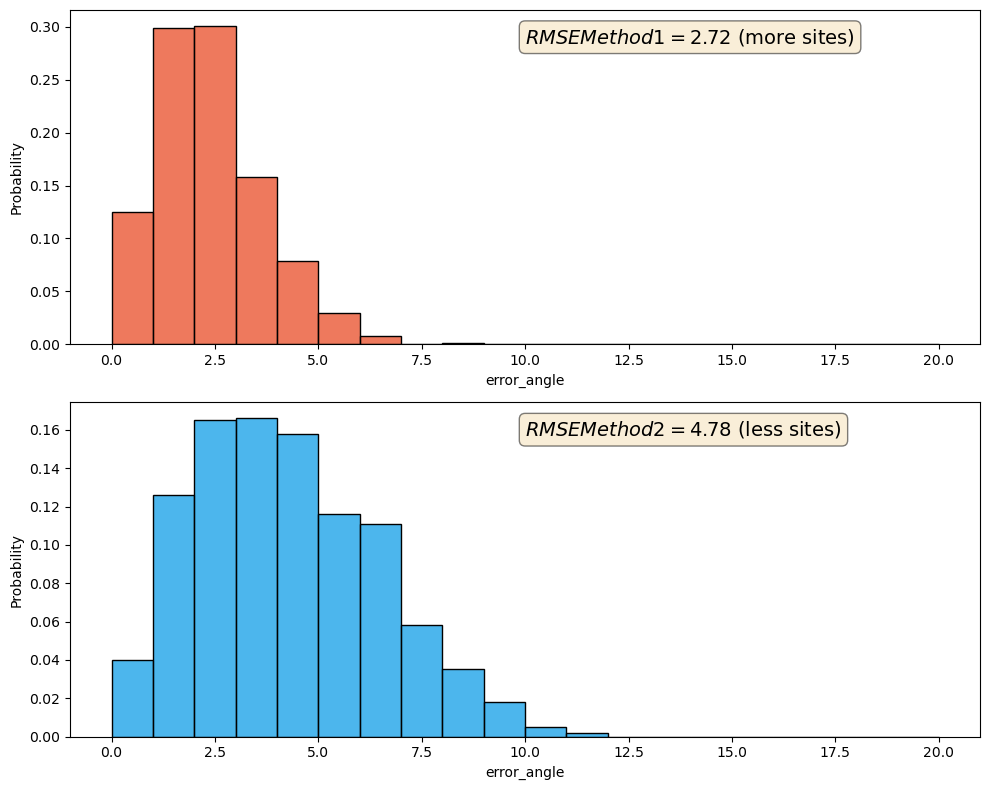

In [13]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

sns.histplot(approach_1_estimates.error_angle, ax=axes[0], color='#e84118', stat='probability', binwidth=1, binrange=(0, 20), alpha=.7)
sns.histplot(approach_2_estimates.error_angle, ax=axes[1], color='#0097e6', stat='probability', binwidth=1, binrange=(0, 20), alpha=.7)



# Display RMSE text in each subplot
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
axes[0].text(0.5, 0.95, f'$RMSE Method 1={rmse_more_sites:.2f}$ (more sites)', 
             transform=axes[0].transAxes, fontsize=14, verticalalignment='top', bbox=props)
axes[1].text(0.5, 0.95, f'$RMSE Method 2={rmse_less_sites:.2f}$ (less sites)', 
             transform=axes[1].transAxes, fontsize=14, verticalalignment='top', bbox=props)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


## Setup 

Our goal is to estimate the paleomagnetic pole $\mu$ for a given period of time or age. For doing so, we are going to recollec a number $n$ samples from $N$ different sites. For each site, consequence of secular variation, we are not observing directly $\mu$, but instead $\mu_i$ as a result of secular variations of the magnetic field. If we compute the Fisher mean $\hat \mu_i$ (the hat symbol will be used always for statistical inferences, in opposition to the _true_ value of the pole), then we hope that the new Fisher mean $\hat \mu$ of the $\hat \mu_i$s will give us a estimate for the paleomagnetic poles that will average out the secular variation. The question we are trying to address here is what is the best recollection design of the sample poles that will lead to a better estimation of the final paleomagnetic pole $\mu$. 

We are going to compare two different strategies for estimating the paleomagnetic pole $\mu$:
- Method 1: Compute the Fisher mean of ALL the sample points afor each site and then compute a second Fisher mean of these site vgps to obtain a final estimation of the true paleomagnetic pole.
- Method 2: Assume we are perfectly able to detect outliers, so we can repeat Method 1 after removing those sample points that are clearly ourliers. 

Since we want to know what is the choice of $n$ and $N$ that will lead to the best estimation of the paleomagnetic pole, we are going to compare these two methods for different strategies. 

## Simulation

We first set the parameter for the two simulations. We do this by defining an object class `Params` that has been implemented inside the package `smpsite`.

In [2]:
angular_dispersio_within_site = 10 # degrees
kappa_within_site = smp.angular2kappa(angular_dispersio_within_site)
latitude = 30
outlier_rate = 0.10
n_iters = 1000

params1 = smp.Params(N=40,
                     n0=1,
                     kappa_within_site=kappa_within_site,
                     site_lat=latitude, 
                     site_long=0,
                     outlier_rate=outlier_rate,
                     secular_method="G",
                     kappa_secular=None)

params2 = smp.Params(N=8,
                     n0=5,
                     kappa_within_site=kappa_within_site,
                     site_lat=latitude, 
                     site_long=0,
                     outlier_rate=outlier_rate,
                     secular_method="G",
                     kappa_secular=None)

assert params1.N * params1.n0 == params2.N * params2.n0, "The two methods don't have the same number of total samples."

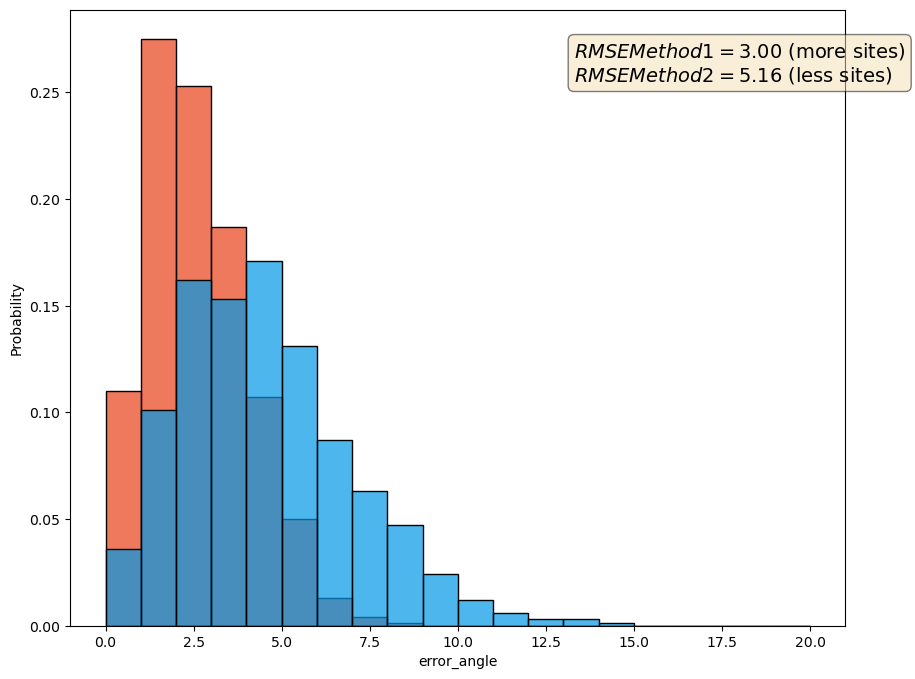

In [4]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,8))

sns.histplot(df_more_sites.error_angle, ax=axes, color='#e84118', stat='probability', binwidth=1, binrange=(0,20), alpha=.7)
sns.histplot(df_less_sites.error_angle, ax=axes, color='#0097e6', stat='probability', binwidth=1, binrange=(0,20), alpha=.7)

textstr = '\n'.join((
r'$RMSE Method 1=%.2f$ (more sites)' % (np.mean(df_more_sites.error_angle**2)**.5, ),
r'$RMSE Method 2=%.2f$ (less sites)' % (np.mean(df_less_sites.error_angle**2)**.5, )))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
# place a text box in upper left in axes coords
plt.text(0.65, 0.95, textstr, transform=axes.transAxes, fontsize=14,
        verticalalignment='top', bbox=props);